In [ ]:
import pandas as pd

tabela = pd.read_csv(r"C:\Users\Usuario\Downloads\jupyter\gols_por_time_e_ano.csv")
display(tabela)

,Ano,Clube 1,Clube 2,Gols_mandante,Gols_visitante,Gols_total
0,2000,Vasco,Sport,26,19,45
1,2000,Vitória,Palmeiras,27,16,43
2,2000,Fluminense,Bahia,21,9,30
3,2000,América-MG,Gama,18,10,28
4,2000,Guarani,Santa Cruz,17,8,25
...,...,...,...,...,...,...
7174,2017,Botafogo,Cruzeiro,30,21,51
7175,2017,Sport,Corinthians,27,18,45
7176,2017,Atlético-GO,Fluminense,18,23,41
7177,2017,Atlético-MG,Grêmio,27,29,56


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, year


# Inicializa a sessão Spark
spark = SparkSession.builder.appName("DesempenhoPorEstado").getOrCreate()
df.printSchema()
#: indica o início da estrutura do DataFrame.


root
 |-- Ano: integer (nullable = true)
 |-- Clube 1: string (nullable = true)
 |-- Clube 2: string (nullable = true)
 |-- Gols_mandante: integer (nullable = true)
 |-- Gols_visitante: integer (nullable = true)
 |-- Gols_total: integer (nullable = true)



In [11]:
from pyspark.sql.functions import col, sum, when
# Conta valores nulos por coluna
df.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in df.columns
]).show()



+---+-------+-------+-------------+--------------+----------+
|Ano|Clube 1|Clube 2|Gols_mandante|Gols_visitante|Gols_total|
+---+-------+-------+-------------+--------------+----------+
|  0|      0|      0|            0|             0|         0|
+---+-------+-------+-------------+--------------+----------+



In [18]:
# Agrupar por Clube 1 (mandante) e somar os gols
gols_mandante = df.groupBy("Clube 1").agg(sum("Gols_mandante").alias("Total_Gols_Mandante"))
# Ordenar do maior para o menor
gols_mandante.orderBy(col("Total_Gols_Mandante").desc()).show()



+-------------+-------------------+
|      Clube 1|Total_Gols_Mandante|
+-------------+-------------------+
|       Santos|              11758|
|     Cruzeiro|              11739|
|    São Paulo|              11450|
|  Atlético-MG|              10476|
|  Atlético-PR|              10277|
|       Grêmio|              10043|
|   Fluminense|               9980|
|     Flamengo|               9670|
|Internacional|               9539|
|  Corinthians|               9451|
|    Palmeiras|               8939|
|        Goiás|               8770|
|     Botafogo|               8680|
|        Vasco|               8493|
|     Coritiba|               7649|
|      Vitória|               6864|
|  Figueirense|               6445|
|  Ponte Preta|               6342|
|        Sport|               5086|
|       Paraná|               4231|
+-------------+-------------------+
only showing top 20 rows


In [ ]:
from pyspark.sql.functions import sum, col

# Agrupar por ano e clube mandante, somando os gols
gols_mandante_ano = df.groupBy("Ano", "Clube 1") \
    .agg(sum("Gols_mandante").alias("Total_Gols_Mandante"))

# Visualizar os dados ordenados por ano e total de gols
gols_mandante_ano.orderBy("Ano", col("Total_Gols_Mandante").desc()).show(100)


+----+-------------+-------------------+
| Ano|      Clube 1|Total_Gols_Mandante|
+----+-------------+-------------------+
|2000|  Ponte Preta|                396|
|2000|        Goiás|                348|
|2000|        Vasco|                338|
|2000|        Sport|                324|
|2000|        Bahia|                299|
|2000|     Cruzeiro|                297|
|2000|      Vitória|                297|
|2000|       Santos|                288|
|2000|   Portuguesa|                276|
|2000|  Atlético-MG|                273|
|2000|    São Paulo|                264|
|2000|Internacional|                260|
|2000|   Fluminense|                252|
|2000|     Flamengo|                242|
|2000|   América-MG|                216|
|2000|     Botafogo|                204|
|2000|  Atlético-PR|                204|
|2000|      Guarani|                204|
|2000|       Grêmio|                204|
|2000|    Juventude|                180|
|2000|  Corinthians|                176|
|2000|     Corit

In [19]:
gols_mandante_ano.filter(col("Ano") == 2000).orderBy(col("Total_Gols_Mandante").desc()).show(100)
#Filtrar por ano específico
#show é a qtde de colunas que quero visualizar dos dados

+----+-------------+-------------------+
| Ano|      Clube 1|Total_Gols_Mandante|
+----+-------------+-------------------+
|2000|  Ponte Preta|                396|
|2000|        Goiás|                348|
|2000|        Vasco|                338|
|2000|        Sport|                324|
|2000|        Bahia|                299|
|2000|     Cruzeiro|                297|
|2000|      Vitória|                297|
|2000|       Santos|                288|
|2000|   Portuguesa|                276|
|2000|  Atlético-MG|                273|
|2000|    São Paulo|                264|
|2000|Internacional|                260|
|2000|   Fluminense|                252|
|2000|     Flamengo|                242|
|2000|   América-MG|                216|
|2000|  Atlético-PR|                204|
|2000|      Guarani|                204|
|2000|     Botafogo|                204|
|2000|       Grêmio|                204|
|2000|    Juventude|                180|
|2000|  Corinthians|                176|
|2000|     Corit

In [20]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

# Criar janela por ano, ordenando pelos gols
janela = Window.partitionBy("Ano").orderBy(col("Total_Gols_Mandante").desc())

# Adicionar ranking
gols_rank = gols_mandante_ano.withColumn("rank", row_number().over(janela))

# Filtrar apenas os primeiros colocados de cada ano
top_gols_por_ano = gols_rank.filter(col("rank") == 1)

# Mostrar resultado
top_gols_por_ano.select("Ano", "Clube 1", "Total_Gols_Mandante").orderBy("Ano").show()



+----+-----------+-------------------+
| Ano|    Clube 1|Total_Gols_Mandante|
+----+-----------+-------------------+
|2000|Ponte Preta|                396|
|2001|      Vasco|                615|
|2002|  São Paulo|                432|
|2003|   Cruzeiro|               1298|
|2004|     Santos|               1364|
|2005|Atlético-PR|               1029|
|2006|     Grêmio|                760|
|2007|   Cruzeiro|                880|
|2008|   Flamengo|                798|
|2009|     Grêmio|               1007|
|2010|Corinthians|                779|
|2011|   Coritiba|                760|
|2012|Atlético-MG|                798|
|2013|   Cruzeiro|                893|
|2014| Fluminense|                760|
|2015|     Santos|                893|
|2016|Atlético-MG|                741|
|2017|  Palmeiras|                665|
+----+-----------+-------------------+



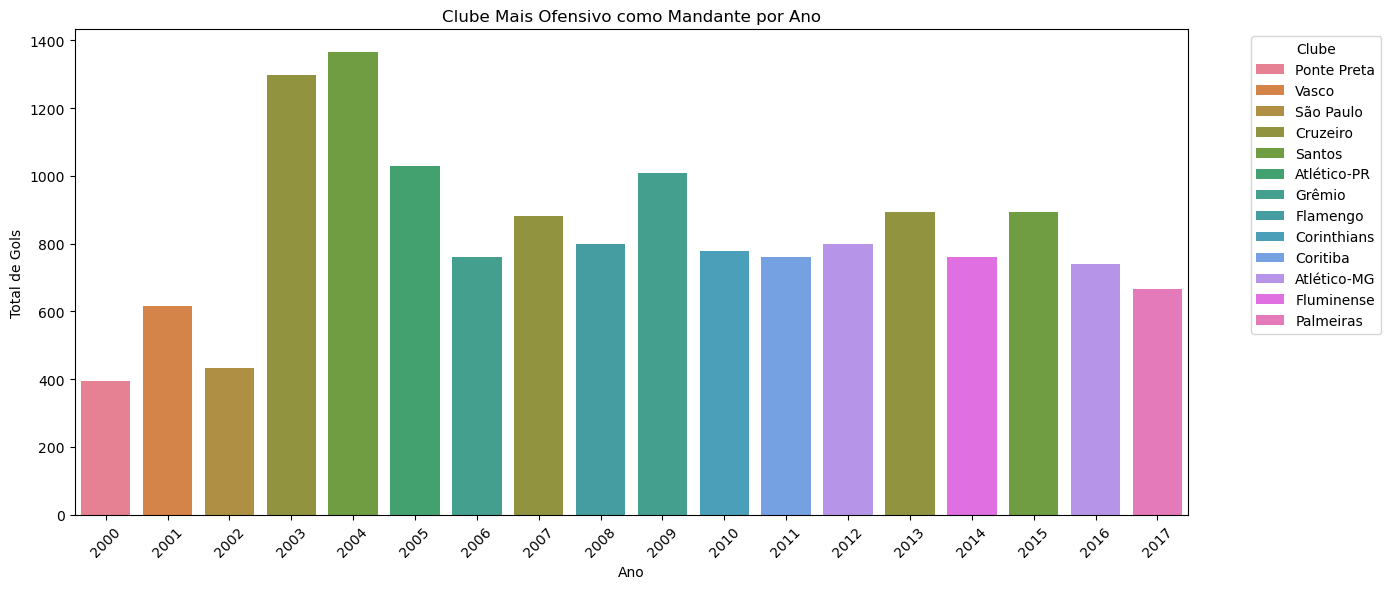

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que você já tenha o DataFrame 'gols_pd' com colunas: Ano, Clube 1, Total_Gols_Mandante
plt.figure(figsize=(14,6))
sns.barplot(data=gols_pd, x="Ano", y="Total_Gols_Mandante", hue="Clube 1")
plt.title("Clube Mais Ofensivo como Mandante por Ano")
plt.xlabel("Ano")
plt.ylabel("Total de Gols")
plt.xticks(rotation=45)
plt.legend(title="Clube", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
